In [14]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import lightgbm as lgb
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
#import pandas_profiling

In [119]:

def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances01.png')

In [16]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

## FE

In [17]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [18]:

var_list = [f for f in train_df.columns if 'var' in f]
mean_var_list = [f+'_over_max_median' for f in train_df.columns if 'var' in f]

# train_df['mean'] = np.mean(train_df[var_list],axis=1)
# train_df['std'] = np.std(train_df[var_list],axis=1)
# train_df['min'] = np.min(train_df[var_list],axis=1)
# train_df['max'] = np.max(train_df[var_list],axis=1)
# train_df['sum'] = np.sum(train_df[var_list],axis=1)
# train_df['median'] = np.median(train_df[var_list],axis=1)

train_df[mean_var_list] = (train_df[var_list]-np.median(train_df[var_list],axis=0))/((np.max(train_df[var_list],axis=0)-np.median(train_df[var_list],axis=0)))
test_df[mean_var_list] = (test_df[var_list]-np.median(test_df[var_list],axis=0))/((np.max(test_df[var_list],axis=0)-np.median(test_df[var_list],axis=0)))


In [19]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190_over_max_median,var_191_over_max_median,var_192_over_max_median,var_193_over_max_median,var_194_over_max_median,var_195_over_max_median,var_196_over_max_median,var_197_over_max_median,var_198_over_max_median,var_199_over_max_median
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-0.309247,0.478768,-0.543584,-0.068832,-0.427915,0.558461,0.145135,0.540112,-0.044474,-0.195661
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,0.433464,0.155920,-0.155798,0.471674,-0.240828,0.135807,-0.287695,0.289270,0.300698,-0.595758
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.227417,0.387095,0.014348,-0.087897,-0.501123,0.486489,-0.703716,-0.541236,0.373025,-0.667686
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,0.372620,0.181805,-0.038381,0.010757,-0.279854,0.706887,0.114899,0.099527,-0.276225,-0.048472
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,0.061844,0.192054,-0.099650,-0.003569,0.158131,-0.026342,-0.559647,-0.474313,-0.190411,-0.210837


## Model

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

n_folds = 5
random_seed = 26
model = 'lgb_over_max_median'


model_name = "{0}_{1}_folds".format(model, n_folds)
print("Model: {}".format(model_name))

Model: lgb_over_max_median_5_folds


In [115]:
#feats = train_df.iloc[:,2:].columns.tolist();feats
feats = [c for c in train_df.columns if c not in ['ID_code', 'target']];feats

['var_0',
 'var_1',
 'var_2',
 'var_3',
 'var_4',
 'var_5',
 'var_6',
 'var_7',
 'var_8',
 'var_9',
 'var_10',
 'var_11',
 'var_12',
 'var_13',
 'var_14',
 'var_15',
 'var_16',
 'var_17',
 'var_18',
 'var_19',
 'var_20',
 'var_21',
 'var_22',
 'var_23',
 'var_24',
 'var_25',
 'var_26',
 'var_27',
 'var_28',
 'var_29',
 'var_30',
 'var_31',
 'var_32',
 'var_33',
 'var_34',
 'var_35',
 'var_36',
 'var_37',
 'var_38',
 'var_39',
 'var_40',
 'var_41',
 'var_42',
 'var_43',
 'var_44',
 'var_45',
 'var_46',
 'var_47',
 'var_48',
 'var_49',
 'var_50',
 'var_51',
 'var_52',
 'var_53',
 'var_54',
 'var_55',
 'var_56',
 'var_57',
 'var_58',
 'var_59',
 'var_60',
 'var_61',
 'var_62',
 'var_63',
 'var_64',
 'var_65',
 'var_66',
 'var_67',
 'var_68',
 'var_69',
 'var_70',
 'var_71',
 'var_72',
 'var_73',
 'var_74',
 'var_75',
 'var_76',
 'var_77',
 'var_78',
 'var_79',
 'var_80',
 'var_81',
 'var_82',
 'var_83',
 'var_84',
 'var_85',
 'var_86',
 'var_87',
 'var_88',
 'var_89',
 'var_90',
 'var_91'

Current Fold: 1
AUC = 0.8919553935389614
getting feature importance
Current Fold: 2
AUC = 0.8904353195806354
getting feature importance
Current Fold: 3
AUC = 0.8951081031750642
getting feature importance
Current Fold: 4
AUC = 0.8945703019053048
getting feature importance
Current Fold: 5
AUC = 0.8926040440757984
getting feature importance
Overall AUC = 0.8927908906108155
Saving submission file


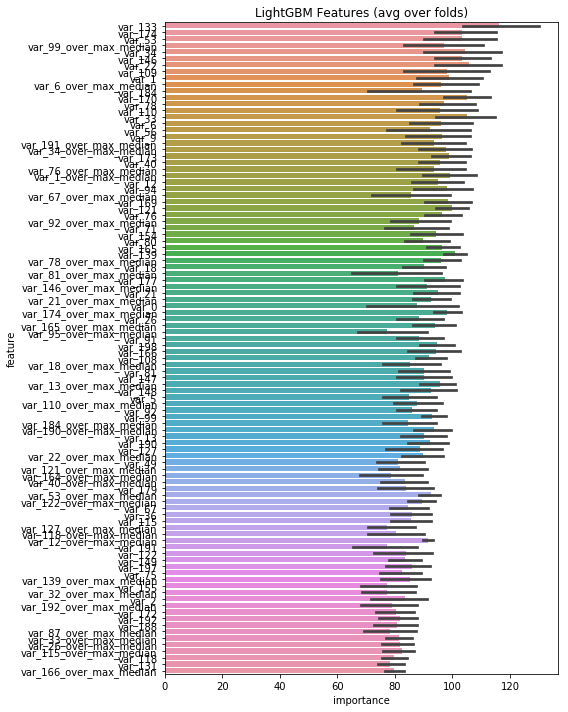

In [116]:
clfs = []
folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
oof_preds = np.zeros((len(train_df), 1))
test_preds = np.zeros((len(test_df), 1))


X = train_df[feats]
y = train_df['target']
X_test = test_df[feats]
test_ids = test_df.ID_code.values


parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    #'scale_pos_weight': 400,
    #'device' : 'gpu' ,
    'boosting': 'gbdt',
    'num_leaves': 31, #31
    'feature_fraction': 0.5,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'learning_rate': 0.05, #0.05
    'verbose': 30
    #'min_data_in_leaf': 200
}

feature_importance_df = pd.DataFrame()
for fold_, (trn_, val_) in enumerate(folds.split(X, y)):
    print("Current Fold: {}".format(fold_+1))
    trn_x, trn_y = X.iloc[trn_, :], y[trn_]
    val_x, val_y = X.iloc[val_, :], y[val_]


    trn_lgb = lgb.Dataset(trn_x, trn_y)
    val_lgb = lgb.Dataset(val_x, val_y)
    clf = lgb.train(parameters,
                     train_set=trn_lgb,
                     #valid_sets=[valid_data_lgb,holdout_data_lgb],
                     valid_sets=[trn_lgb, val_lgb],
                     num_boost_round=3000,
                     early_stopping_rounds=50,
                     verbose_eval=False)
    


    val_pred = clf.predict(val_x)
    test_fold_pred = clf.predict(X_test)

    print("AUC = {}".format(roc_auc_score(val_y, val_pred)))
    oof_preds[val_, :] = val_pred.reshape((-1, 1))
    test_preds += test_fold_pred.reshape((-1, 1))
    
    print('getting feature importance')
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    
test_preds /= n_folds
roc_score = roc_auc_score(y, oof_preds.ravel())
print("Overall AUC = {}".format(roc_score))


print("Saving submission file")
sample = pd.read_csv('../data/sample_submission.csv')
sample.target = test_preds.astype(float)
sample.ID_code = test_ids
sample.to_csv('../submissions/{}_{}.csv'.format(model_name,str(roc_score)), index=False)

display_importances(feature_importance_df)


In [23]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [24]:


shutil.copyfile(os.path.basename(NOTEBOOK_FULL_PATH), 
                             '../models/{}_{}.ipynb'.format(model_name, str(roc_score)))


'../models/lgb_over_max_median_5_folds_0.8927908906108155.ipynb'

In [36]:
clf.predict(val_x.iloc[0],pred_contrib=True)

C:\Users\TanQ\AppData\Local\Continuum\anaconda3\envs\work\lib\site-packages\lightgbm\basic.py:452: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


array([[-3.93268843e-02, -3.70502267e-02,  7.20410447e-02,
        -5.14794659e-03, -3.36656922e-03,  1.18189760e-01,
        -2.03232768e-02, -2.43534530e-03,  2.06846570e-02,
        -2.30367336e-02, -3.05631523e-03,  7.17579562e-02,
        -3.60610582e-02,  2.39898732e-02,  1.18249116e-02,
        -3.05180717e-03,  2.51868135e-02,  2.89458050e-03,
        -4.18144826e-02,  4.30009116e-02,  9.36178792e-02,
         2.17325798e-01,  1.98014155e-01, -3.47866363e-02,
        -3.78195873e-02,  1.26590884e-02, -4.96251022e-02,
         2.79162055e-04,  2.34828771e-02, -3.38617033e-03,
         4.72025758e-04,  9.75963642e-02,  1.30248245e-02,
        -8.09505272e-02,  9.54451387e-03, -4.69094399e-02,
        -3.90603161e-02, -2.87577091e-03,  7.55222173e-04,
        -4.74092681e-03, -4.28867229e-02,  1.40182843e-02,
         2.10805601e-02, -4.70198097e-02,  7.82518234e-02,
         5.21578368e-02, -6.75091211e-03,  4.50467751e-03,
         7.49051159e-02,  2.25519916e-02,  1.62397812e-0

In [62]:
result_df = pd.DataFrame(data=clf.predict(val_x.iloc[:10],pred_contrib=True))
result_df['prediction'] = clf.predict(val_x.iloc[:10])
#result_df[val_x.columns.tolist()] = clf.predict(val_x.iloc[:10],pred_contrib=True)


In [65]:
result_df.columns = val_x.columns.tolist()+['baseline_pred'] +['final_pred']

In [71]:
result_df =  result_df[['final_pred'] + ['baseline_pred'] + val_x.columns.tolist()]

In [89]:
result_df.iloc[0,1:].sum()

0.28812681658719375

In [113]:
result_df.iloc[:,:9]


,final_pred,baseline_pred,var_0,var_1,var_2,var_3,var_4,var_5,var_6
0,0.571537,-1.701885,-0.039327,-0.037050,0.072041,-0.005148,-0.003367,0.118190,-0.020323
1,0.056427,-1.701885,-0.034855,-0.013877,0.012534,0.001982,-0.006649,-0.045968,0.422089
2,0.131655,-1.701885,-0.044732,-0.013932,0.052405,-0.001917,-0.003318,0.014513,-0.065764
3,0.540031,-1.701885,-0.032672,-0.002076,-0.070309,-0.007568,-0.008739,-0.042647,0.054001
4,0.329536,-1.701885,0.027451,0.072701,0.429397,-0.003370,0.014742,-0.030384,-0.004369
5,0.311653,-1.701885,0.156970,-0.085969,-0.063579,-0.006659,0.003810,-0.010470,-0.043518
6,0.568784,-1.701885,-0.023433,-0.019481,0.054250,-0.007657,-0.048572,-0.002471,0.018791
7,0.117736,-1.701885,-0.037030,0.015511,-0.020845,-0.003590,-0.010960,-0.030726,-0.071401
8,0.055309,-1.701885,-0.053260,0.001029,0.082322,-0.005337,-0.008556,0.002953,0.101039
9,0.055792,-1.701885,-0.053844,-0.025975,-0.089981,0.038213,-0.010739,-0.069373,-0.057705


In [109]:
result_df.iloc[1,2:].sum()

-1.1148467489322968

In [107]:
a = result_df.iloc[0,1].sum()

In [110]:
1/(1+np.exp(a))

0.7530315906570576